In [1]:
from scipy.stats import truncnorm, multivariate_normal, norm
import numpy as np
import matplotlib.pyplot as plt
import time
import seaborn as sns

In [2]:
# Parameters
mu_1 = 20
mu_2 = 20
sigma_1 = 2
sigma_2 = 2
sigma_t = 0.5
iterations = 100

GIBBS SAMPLER

In [3]:
# Helper function to sample from a truncated normal distribution
def truncated_normal(mean, std, lower, upper):
    a, b = (lower - mean) / std, (upper - mean) / std
    return truncnorm.rvs(a, b, loc=mean, scale=std)

In [4]:
# Gibbs Sampler
def gibbs_sampler(y, iterations):
    # Initialize t
    if y == 1:
        t = np.abs(np.random.randn())
    else:
        t = -np.abs(np.random.randn())

    
    samples = []
    
    for i in range(iterations):
        # p(s1,s2|t,y)
        # p(S|t,y)
        # QUESTION 3.1
        # Step 1: Draw s_1 and s_2 from the conditional distribution N(mean_s|t, cov_s|t) -
        # (2x2)
        cov_s_t = np.linalg.inv(np.array([[(sigma_1**2 + sigma_t**2) / (sigma_1**2 * sigma_t**2), -1/sigma_t**2],
                                          [-1/sigma_t**2, (sigma_2**2 + sigma_t**2) / (sigma_2**2 * sigma_t**2)]]))
        # (1x2)
        mean_s_t = np.dot(cov_s_t, np.array([mu_1 * sigma_t**2 + t * sigma_1**2 / (sigma_1**2 * sigma_t**2),
                                             mu_2 * sigma_t**2 - t * sigma_2**2 / (sigma_2**2 * sigma_t**2)]))
        
        # Draw from the multivariate normal distribution
        s_1, s_2 = multivariate_normal.rvs(mean=mean_s_t, cov=cov_s_t)

        #DO WE NEED TO UPDATE: mu_1 +mu_2, sigma_1, sigma_2 ??????????????????????????????????????????????????????????????????????????

        #p(t | s_1, s_2, y)
        #p(t | S, y)

        # QUESTION 3.2
        # Step 2: Draw t from the conditional distribution 
        mean_t = s_1 - s_2 

        if y == 1:
            t = truncated_normal(mean_t, sigma_t, 0, np.inf)  # For y = 1, t > 0
        else:
            t = truncated_normal(mean_t, sigma_t, -np.inf, 0)  # For y = -1, t < 0

        # Store samples
        samples.append((s_1, s_2, t))

    return np.array(samples)


In [5]:
# Example execution of the sampler for y = 1
samples = gibbs_sampler(y=1, iterations)

# Extract s_1, s_2, and t samples
s_1_samples, s_2_samples, t_samples = samples[:, 0], samples[:, 1], samples[:, 2]

print(samples.shape)
print(samples[0])

#s_1_samples, s_2_samples, t_samples 

(100, 3)
[21.9982625  20.3492948   1.05374019]


Trace Plot before Burn-in 

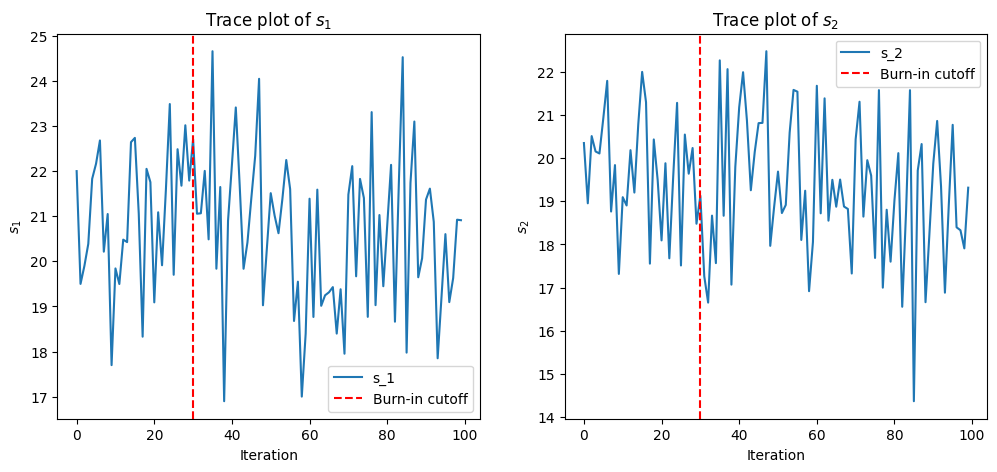

In [6]:
burn_in = int(0.3 * iterations)

# Trace plots to determine the burn-in period
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(s_1_samples, label="s_1")
plt.axvline(x=burn_in, color='r', linestyle='--', label='Burn-in cutoff')
plt.title("Trace plot of $s_1$")
plt.xlabel("Iteration")
plt.ylabel("$s_1$")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(s_2_samples, label="s_2")
plt.axvline(x=burn_in, color='r', linestyle='--', label='Burn-in cutoff')
plt.title("Trace plot of $s_2$")
plt.xlabel("Iteration")
plt.ylabel("$s_2$")
plt.legend()
plt.show()

TRACE PLOT AFTER BURN IN

In [7]:
s_1_filtered = s_1_samples[burn_in:]
s_2_filtered = s_2_samples[burn_in:]

skills_filtered = np.column_stack((s_1_filtered, s_2_filtered))

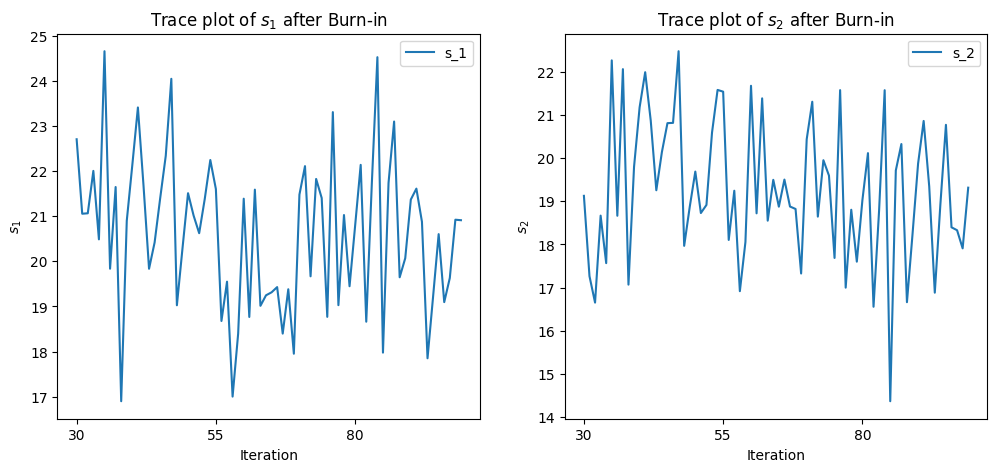

In [8]:
# Trace plots to show iterations after burn-in period
plt.figure(figsize=(12, 5))

# Plot for s_1 after burn-in
plt.subplot(1, 2, 1)
plt.plot(s_1_filtered, label="s_1")  # Plotting from burn_in onwards
plt.title("Trace plot of $s_1$ after Burn-in")
plt.xlabel("Iteration")
plt.ylabel("$s_1$")
plt.xticks(ticks=np.arange(0, len(s_1_samples[burn_in:]), step=25), labels=np.arange(burn_in, len(s_1_samples), step=25))  # X-Achse anpassen
plt.legend()

# Plot for s_2 after burn-in
plt.subplot(1, 2, 2)
plt.plot(s_2_filtered, label="s_2")  # Plotting from burn_in onwards
plt.title("Trace plot of $s_2$ after Burn-in")
plt.xlabel("Iteration")
plt.ylabel("$s_2$")
plt.xticks(ticks=np.arange(0, len(s_2_samples[burn_in:]), step=25), labels=np.arange(burn_in, len(s_2_samples), step=25))  # X-Achse anpassen
plt.legend()

plt.show()


HISTOGRAM TOGETHER WITH FITTED GAUSSIAN POSTERIOR

QUESTION 4.2 Approximate samples by a multivariate normal distibution

In [9]:
def gaussian_approximation(samples):
    mean = np.mean(samples, axis = 0)
    covariance = np.cov(samples, rowvar = False) # rowvar=False ensures we calculate cov among players (columns)
    # Creating a multivariate normal distribution object
    gaussian_dist = multivariate_normal(mean=mean, cov=covariance)
    return gaussian_dist

gaussian_dist = gaussian_approximation(skills_filtered)


# Print the mean and covariance of the approximated Gaussian distribution
print("Mean of the approximated Gaussian distribution:", gaussian_dist.mean)
print("Covariance matrix of the approximated Gaussian distribution:", gaussian_dist.cov)

Mean of the approximated Gaussian distribution: [20.61149707 19.26686995]
Covariance matrix of the approximated Gaussian distribution: [[2.84167946 2.15160739]
 [2.15160739 2.72547676]]


QUESTION 4.3 Plot Function - Gaussian Approximation and Histograms for Samples from Gibbs Sampler

In [41]:
# Function to generate the plot layout for each sample size
def plot_gaussian_with_histograms(ax_contour, ax_histx, ax_histy, samples, num_samples, elapsed_time):
    # Extract the range of s1 and s2
    s1_min, s1_max = np.min(samples[:, 0]), np.max(samples[:, 0])
    s2_min, s2_max = np.min(samples[:, 1]), np.max(samples[:, 1])

    # Set limits for the contour plot based on the data range
    ax_contour.set_xlim(s1_min, s1_max)
    ax_contour.set_ylim(s2_min, s2_max)

    # Create a grid for the 2D distribution based on the data range
    x, y = np.mgrid[s1_min:s1_max:100j, s2_min:s2_max:100j]  # Adjust grid range
    pos = np.dstack((x, y))

    # Fit the multivariate Gaussian to your data (optional, depends on what you're doing)
    gaussian_dist = gaussian_approximation(samples)

    # Plot the 2D contour plot using the Gaussian approximation
    ax_contour.contourf(x, y, gaussian_dist.pdf(pos), cmap='Blues')
    ax_contour.scatter(samples[:, 0], samples[:, 1], s=5, color='r', alpha=0.5, label="Samples")
    ax_contour.set_xlabel('s1')
    ax_contour.set_ylabel('s2')
    ax_contour.set_title(f'{num_samples} samples, Time: {elapsed_time:.2f} sec')

    # Plot the histogram for s1 (top)
    ax_histx.hist(samples[:, 0], bins=30, density=True, alpha=0.6, color='g', label="Histogram (s1)")
    x_vals = np.linspace(s1_min, s1_max, 100)
    ax_histx.plot(x_vals, norm.pdf(x_vals, gaussian_dist.mean[0], np.sqrt(gaussian_dist.cov[0, 0])), 'g-', lw=2, label="Gaussian fit (s1)")
    ax_histx.set_xlim(s1_min, s1_max)  # Set x-axis limits for s1 histogram
    ax_histx.set_ylabel('Density')

    # Plot the histogram for s2 (right)
    ax_histy.hist(samples[:, 1], bins=30, density=True, orientation='horizontal', alpha=0.6, color='b', label="Histogram (s2)")
    y_vals = np.linspace(s2_min, s2_max, 100)
    ax_histy.plot(norm.pdf(y_vals, gaussian_dist.mean[1], np.sqrt(gaussian_dist.cov[1, 1])), y_vals, 'purple', lw=2, label="Gaussian fit (s2)")
    ax_histy.set_ylim(s2_min, s2_max)  # Set y-axis limits for s2 histogram
    ax_histy.set_xlabel('Density')

Plot for 4 different sample_sizes

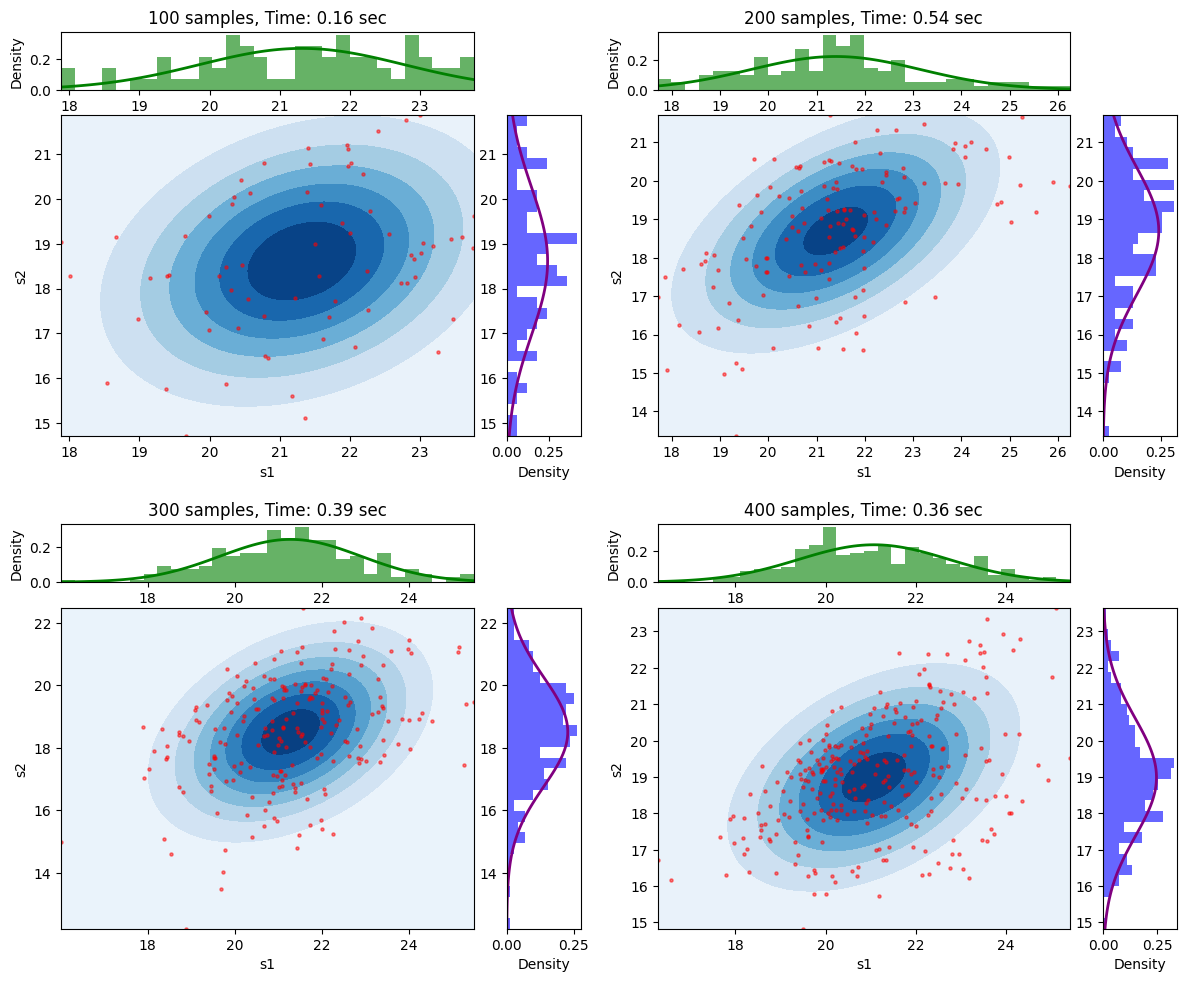

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal, norm
import time

#sample_sizes = [100, 500, 1000, 5000]
sample_sizes = [iterations * i for i in range(1, 5)]
#sample_sizes = [iterations * i**2 for i in range(1, 5)]

# Create a figure with 2x2 subplots
fig1, axes1 = plt.subplots(2, 2, figsize=(12, 10))  # For 1&2 in first row, 3&4 in second row

# Loop through your own sample sizes (for demonstration, using the same data multiple times)
#sample_sizes = [100, 500, 1000, 5000]  # Modify this as needed to match your data
for i, num_samples in enumerate(sample_sizes):
    # Measure the time taken to generate the samples (or just simulate this if you're using pre-existing data)
    start_time = time.time()

    # For your own data, simply subset or repeat it if needed
    #samples = samples_own[:num_samples]
    samples = gibbs_sampler(y=1, iterations=num_samples)

    # Extract s1, s2, and t from the samples
    s_1_samples, s_2_samples, t_samples = samples[:, 0], samples[:, 1], samples[:, 2]

    # Apply burn-in to remove the initial samples
    burn_in = int(0.3 * num_samples)
    s_1_filtered = s_1_samples[burn_in:]
    s_2_filtered = s_2_samples[burn_in:]

    # Combine filtered s1 and s2 into a single array
    skills_filtered = np.column_stack((s_1_filtered, s_2_filtered))

    # Measure elapsed time for generating samples
    elapsed_time = time.time() - start_time

    # Determine which subplot to use based on index
    row, col = divmod(i, 2)  # Row and column index (0 or 1)
    ax_contour = axes1[row, col]  # Use the correct subplot

    # Set up the shared axes for the histograms with more padding for spacing
    ax_histx = axes1[row, col].inset_axes([0, 1.08, 1, 0.18], transform=axes1[row, col].transAxes)  # Top histogram for s1
    ax_histy = axes1[row, col].inset_axes([1.08, 0, 0.18, 1], transform=axes1[row, col].transAxes)  # Right histogram for s2

    # Call the plotting function to display the results in this subplot
    plot_gaussian_with_histograms(ax_contour, ax_histx, ax_histy, skills_filtered, num_samples, elapsed_time)

# Adjust layout and show the combined figure with two sets of plots (2x2 grid)
plt.tight_layout()
plt.show()


QUESTION 4.4 COMPARE PRIOR p(s1) and p(s2) with POSTERIOR p(s1|y=1) and p(s2|y=1) based on results Gibbs sampler and gaussian approximation of the posterior

In [45]:
print("Mean of the approximated Gaussian distribution:", gaussian_dist.mean)
print("Covariance matrix of the approximated Gaussian distribution:", gaussian_dist.cov)

Mean of the approximated Gaussian distribution: [20.61149707 19.26686995]
Covariance matrix of the approximated Gaussian distribution: [[2.84167946 2.15160739]
 [2.15160739 2.72547676]]


In [50]:
mu_1_post = gaussian_dist.mean[0]  # Mean of the posterior for s1
sigma_1_post = np.sqrt(gaussian_dist.cov[0, 0])  # Std dev of the posterior for s1
mu_2_post = gaussian_dist.mean[1]  # Mean of the posterior for s2
sigma_2_post = np.sqrt(gaussian_dist.cov[1, 1])  # Std dev of the posterior for s2

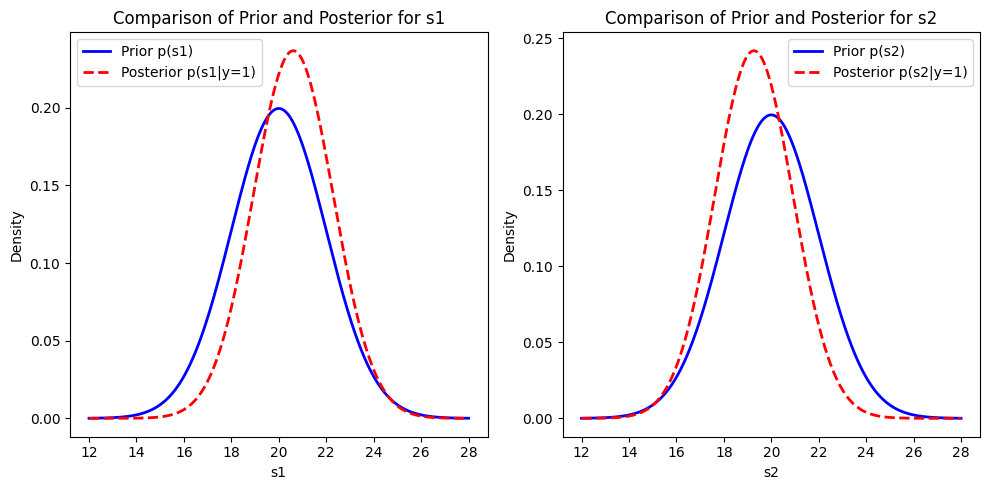

In [49]:
# Plot the prior and posterior for s1
x_s1 = np.linspace(mu_1 - 4*sigma_1, mu_1 + 4*sigma_1, 1000)
prior_s1 = norm.pdf(x_s1, mu_1, sigma_1)
posterior_s1 = norm.pdf(x_s1, mu_1_post, sigma_1_post)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(x_s1, prior_s1, label="Prior p(s1)", color='blue', lw=2)
plt.plot(x_s1, posterior_s1, label="Posterior p(s1|y=1)", color='red', lw=2, linestyle='dashed')
plt.title("Comparison of Prior and Posterior for s1")
plt.xlabel("s1")
plt.ylabel("Density")
plt.legend()

# Plot the prior and posterior for s2
x_s2 = np.linspace(mu_2 - 4*sigma_2, mu_2 + 4*sigma_2, 1000)
prior_s2 = norm.pdf(x_s2, mu_2, sigma_2)
posterior_s2 = norm.pdf(x_s2, mu_2_post, sigma_2_post)

plt.subplot(1, 2, 2)
plt.plot(x_s2, prior_s2, label="Prior p(s2)", color='blue', lw=2)
plt.plot(x_s2, posterior_s2, label="Posterior p(s2|y=1)", color='red', lw=2, linestyle='dashed')
plt.title("Comparison of Prior and Posterior for s2")
plt.xlabel("s2")
plt.ylabel("Density")
plt.legend()

plt.tight_layout()
plt.show()